In [102]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from pyvis.network import Network
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import re
import jieba
import jieba.analyse
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1: Load the data 載入資料</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Dataset Information 資料集資訊</div>

# PTT AI 討論資料集介紹

## 資料集概覽

此資料集包含有關 AI 的討論，收集自台灣的社群媒體平台 PTT。資料收集範圍從 2022 年 1 月 1 日到 2024 年 5 月 31 日，共包含 2,172 筆資料。

## 資料欄位說明

資料集包含以下 11 個欄位：

1. `system_id`: 系統編號，總共 2172 筆，無空值。
2. `artComment`: 文章評論，總共 2172 筆，無空值。
3. `artDate`: 文章日期，總共 2172 筆，無空值。
4. `insertedDate`: 插入日期，總共 2172 筆，無空值。
5. `artContent`: 文章內容，總共 2172 筆，無空值。
6. `artCatagory`: 文章類別，總共 2172 筆，無空值。
7. `dataSource`: 資料來源，總共 2172 筆，無空值，全部來自 PTT。
8. `artPoster`: 發文者，總共 2172 筆，無空值。
9. `artTitle`: 文章標題，總共 2172 筆，無空值。
10. `artUrl`: 文章網址，總共 2172 筆，無空值。

## 記憶體使用情況

- 資料集大小： 186.8+ KB
- 資料型態：整數 (int64) 1 欄，物件 (object) 9 欄

In [2]:
df = pd.read_csv('data/ptt_ai_221130to240531.csv')
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,ggglu,Finance,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""cow38"", ""cmt...",118.168.142.101,2022-02-16 00:12:45,ptt
1,2,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,[新聞]台銀「三駕馬車」戰略發威前4月,2022-05-21 02:29:23,make1302,Finance,（中央社記者張璦台北20日電）台灣銀行消金、企金、政府部門業務「三駕馬車」再發威\r\n，董...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""DerLuna"", ""c...",118.171.234.47,2022-05-22 01:11:41,ptt
2,3,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,[新聞]央行徵才月薪最高86K,2023-02-14 11:45:19,kria5304,Finance,https://tinyurl.com/3fcp6ehh\r\n記者陳美君／台北報導\r\n...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""fill725258"",...",36.224.200.45,2023-02-15 01:06:37,ptt
3,4,https://www.ptt.cc/bbs/Finance/M.1698684536.A....,[新聞]證交所徵才開創數位驅動時代報名至11/17,2023-10-31 00:48:54,BangBang5566,Finance,證交所徵才開創數位驅動時代 報名至11/17止\r\n\r\n中央社\r\n2023年10月...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Laviathan"", ...",42.70.143.5,2023-10-31 01:10:55,ptt
4,5,https://www.ptt.cc/bbs/job/M.1641165773.A.E67....,[台中][西屯］飛斯戴爾有限公司/日文客服,2022-01-03 07:22:51,howdigh,job,job版禁止張貼違反「\r\n就業服務法\r\n」、\r\n「\r\n性別平等工作法\r\n...,[],125.230.247.67,2022-01-04 00:58:48,ptt


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 2171
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   system_id     2172 non-null   int64 
 1   artUrl        2172 non-null   object
 2   artTitle      2172 non-null   object
 3   artDate       2172 non-null   object
 4   artPoster     2172 non-null   object
 5   artCatagory   2172 non-null   object
 6   artContent    2172 non-null   object
 7   artComment    2172 non-null   object
 8   e_ip          2126 non-null   object
 9   insertedDate  2172 non-null   object
 10  dataSource    2172 non-null   object
dtypes: int64(1), object(10)
memory usage: 186.8+ KB


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the font 載入字型</div>

In [5]:
# Path to the custom font
font_path = 'font/TraditionalChinese.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break

Found font: Noto Sans TC


In [6]:
plt.rcParams['font.family'] = 'Noto Sans TC'
plt.rcParams['axes.unicode_minus'] = False

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2: Data Preprocessing 資料前處理</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Data Cleaning 資料清理</div>

In [7]:
# 複製原始資料集
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','，', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

# 只留下中文字
clear_df['sentence'] = clear_df['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

clear_df.head(10)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...
1,2,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,[新聞]台銀「三駕馬車」戰略發威前4月,2022-05-21 02:29:23,（中央社記者張璦台北20日電）台灣銀行消金、企金、政府部門業務「三駕馬車」再發威\r\n，董...,中央社記者張璦台北日電台灣銀行消金企金政府部門業務三駕馬車再發威董事長呂桔誠今天表示台銀今年...
2,3,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,[新聞]央行徵才月薪最高86K,2023-02-14 11:45:19,https://tinyurl.com/3fcp6ehh\r\n記者陳美君／台北報導\r\n...,記者陳美君台北報導年月日週二上午擁抱金飯碗的機會來了中央銀行近日公開徵才開出的職缺包括經濟金...
3,4,https://www.ptt.cc/bbs/Finance/M.1698684536.A....,[新聞]證交所徵才開創數位驅動時代報名至11/17,2023-10-31 00:48:54,證交所徵才開創數位驅動時代 報名至11/17止\r\n\r\n中央社\r\n2023年10月...,證交所徵才開創數位驅動時代報名至止中央社年月日週一下午中央社記者潘智義台北年月日電台灣證券交...
4,5,https://www.ptt.cc/bbs/job/M.1641165773.A.E67....,[台中][西屯］飛斯戴爾有限公司/日文客服,2022-01-03 07:22:51,job版禁止張貼違反「\r\n就業服務法\r\n」、\r\n「\r\n性別平等工作法\r\n...,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...
5,6,https://www.ptt.cc/bbs/job/M.1641369547.A.B96....,[台北]國立臺灣師範大學教育部計畫專任助理,2022-01-05 15:59:05,job版禁止張貼違反「\r\n就業服務法\r\n」、\r\n「\r\n性別平等工作法\r\n...,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...
6,7,https://www.ptt.cc/bbs/job/M.1642053918.A.308....,[北部]林口長庚醫院醫療AI中心誠徵統計分析助理,2022-01-13 14:05:16,job版禁止張貼違反「\r\n就業服務法\r\n」、\r\n「\r\n性別平等工作法\r\n...,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...
7,8,https://www.ptt.cc/bbs/job/M.1642382909.A.5D7....,[台北]國立臺灣師範大學教育部計畫專任助理,2022-01-17 09:28:27,job版禁止張貼違反「\r\n就業服務法\r\n」、\r\n「\r\n性別平等工作法\r\n...,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...
8,9,https://www.ptt.cc/bbs/job/M.1642668761.A.F44....,[台北]三軍總醫院AIoT中心誠徵博士級研究員,2022-01-20 16:52:39,job版禁止張貼違反「\r\n就業服務法\r\n」、\r\n「\r\n性別平等工作法\r\n...,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...
9,10,https://www.ptt.cc/bbs/job/M.1642761016.A.4BA....,"[台北]4w+薪商標專利業務行銷撰稿,專利師",2022-01-21 18:30:13,job版禁止張貼違反「\r\n就業服務法\r\n」、\r\n「\r\n性別平等工作法\r\n...,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Setup Jieba 斷詞設定</div>

In [113]:
# 初始化斷詞引擎
jieba.set_dictionary('dict/dict.txt') 

# 載入自定義辭典：一個詞一行，每行分詞語、詞頻(可省)、詞性(可省)
jieba.load_userdict('dict/user_dict.txt')

# 參數形式手動將字詞加入斷詞字典
words = ["行動或市內電話"]
for w in words:
    jieba.add_word(w, freq=None, tag=None)

Building prefix dict from C:\Users\user\Documents\GitHub\SocialMediaAnalysisAboutAITrend\dict\dict.txt ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.u27974624d77d101da4cc5720e1cd584d.cache
Loading model cost 0.231 seconds.
Prefix dict has been built successfully.


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Setup Stopwords 設定停用字</div>

In [112]:
# 對於這段文字所定義的停用字列表
with open(f'./dict/text_stopwords.txt', 'r', encoding="utf8") as f:
    stopwords = f.read().splitlines()  #移除換行符號\n

# 參數形式手動加入停用字
user_stop = [
    "的", "來", "對於", "愈來愈", "就是", "什麼",
    "空白", "00", "同義文字", "email", "站各級", "延長工時",
    "電子郵件", "市內電話", "條款", "限制", "應注意", "條文", "註明", "保",
    "詳盡", "資訊", "規範", "本條", "網站", "項", "留", "單位", "名稱", "法律",
    "條例", "使用者", "特殊", "條件", "時間", "內容", "其餘項目", "但不得", "本",
    "為每小時", "單位者", "為每小時", "依", "行", "相關", "第一項", "其他",
    "protected", "未註明", "現行法律", "其餘項留", "情況", "具體"
    "目前", "包含", "進行", "指出", "可以", "認為", "包括", "注意事項",
    "同時", "問題", "影響", "因此", "以及", "發展", "the", "and", '表示', '我們', '可能', '原文標題', '原文連結',
    '原文內容', 'in', 'on', 'for', 'that', 'our', '請務必', '務必詳述'
    '心得評論', '工作', '使用', '現在', '已經', '因為', '自己', '透過', '他們', '提供', '開始', '不過', '需要',
    '記者署名', '去年', '成為', '針對', '如果', '甚至', '推出', '出現', '部分', '領域', '開發', '政府', '所以', '方式',
    '希望', '還是', '能力', '由於', '除了', '請具體', '方面', '獲得', '主要', '過去', '提升', '該公司', '資料', '此外',
    '報導', '生產', '能夠', '例如', '詳述狀況', '強調', '解決方案', '是否', '非常', '以上', '研究', '無法', '成功',
    '結果', '完成', '不同', '這樣', '如何', '機會', '安全', '數據', '處理', '研發', '宣布', '模型', '記者', '重要',
    '國家', '預估', '直接', '設備', '業者', '網路', '擁有', '之一', '另外', '利用', '必須', '支持', '成本', '應用',
    '一個', '人工智慧', 'AI', '公司', '市場', '億美元', '美元', 'rs', '這些', '表現', 'of', '持續', '雖然', '億元',
    '根據', '團隊', '隨著', '客戶', '其中', 'to', '這個', '未來', '平台', '產業', '產品', '今年', '今天', '預計', '預期']

for i in user_stop:
    stopwords.append(i)

pd.DataFrame(stopwords, columns=['停用詞'])

,停用詞
0,，
1,「
2,」
3,、
4,。
...,...
195,產品
196,今年
197,今天
198,預計


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Define Tokenization Function 定義斷詞函數</div>

In [22]:
# 設定斷詞 function
def get_token(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1]

    return seg_list

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Tokenization 斷詞</div>

In [23]:
tqdm.pandas()

data = clear_df.copy()

# 斷詞、去除停用字並將word欄位展開
data['word'] = data.sentence.progress_apply(get_token).explode('word')

data.head(10)

100%|██████████| 2172/2172 [00:04<00:00, 474.24it/s]


,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,實習
1,2,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,[新聞]台銀「三駕馬車」戰略發威前4月,2022-05-21 02:29:23,（中央社記者張璦台北20日電）台灣銀行消金、企金、政府部門業務「三駕馬車」再發威\r\n，董...,中央社記者張璦台北日電台灣銀行消金企金政府部門業務三駕馬車再發威董事長呂桔誠今天表示台銀今年...,普匯
2,3,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,[新聞]央行徵才月薪最高86K,2023-02-14 11:45:19,https://tinyurl.com/3fcp6ehh\r\n記者陳美君／台北報導\r\n...,記者陳美君台北報導年月日週二上午擁抱金飯碗的機會來了中央銀行近日公開徵才開出的職缺包括經濟金...,金融
3,4,https://www.ptt.cc/bbs/Finance/M.1698684536.A....,[新聞]證交所徵才開創數位驅動時代報名至11/17,2023-10-31 00:48:54,證交所徵才開創數位驅動時代 報名至11/17止\r\n\r\n中央社\r\n2023年10月...,證交所徵才開創數位驅動時代報名至止中央社年月日週一下午中央社記者潘智義台北年月日電台灣證券交...,科技
4,5,https://www.ptt.cc/bbs/job/M.1641165773.A.E67....,[台中][西屯］飛斯戴爾有限公司/日文客服,2022-01-03 07:22:51,job版禁止張貼違反「\r\n就業服務法\r\n」、\r\n「\r\n性別平等工作法\r\n...,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...,職缺
5,6,https://www.ptt.cc/bbs/job/M.1641369547.A.B96....,[台北]國立臺灣師範大學教育部計畫專任助理,2022-01-05 15:59:05,job版禁止張貼違反「\r\n就業服務法\r\n」、\r\n「\r\n性別平等工作法\r\n...,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...,徵求
6,7,https://www.ptt.cc/bbs/job/M.1642053918.A.308....,[北部]林口長庚醫院醫療AI中心誠徵統計分析助理,2022-01-13 14:05:16,job版禁止張貼違反「\r\n就業服務法\r\n」、\r\n「\r\n性別平等工作法\r\n...,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...,商管
7,8,https://www.ptt.cc/bbs/job/M.1642382909.A.5D7....,[台北]國立臺灣師範大學教育部計畫專任助理,2022-01-17 09:28:27,job版禁止張貼違反「\r\n就業服務法\r\n」、\r\n「\r\n性別平等工作法\r\n...,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...,科系
8,9,https://www.ptt.cc/bbs/job/M.1642668761.A.F44....,[台北]三軍總醫院AIoT中心誠徵博士級研究員,2022-01-20 16:52:39,job版禁止張貼違反「\r\n就業服務法\r\n」、\r\n「\r\n性別平等工作法\r\n...,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...,曾經
9,10,https://www.ptt.cc/bbs/job/M.1642761016.A.4BA....,"[台北]4w+薪商標專利業務行銷撰稿,專利師",2022-01-21 18:30:13,job版禁止張貼違反「\r\n就業服務法\r\n」、\r\n「\r\n性別平等工作法\r\n...,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...,接觸


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3: Data Analysis 資料分析</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Copy the data 複製資料</div>

In [24]:
ai_df = clear_df.copy()
ai_df.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...
1,2,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,[新聞]台銀「三駕馬車」戰略發威前4月,2022-05-21 02:29:23,（中央社記者張璦台北20日電）台灣銀行消金、企金、政府部門業務「三駕馬車」再發威\r\n，董...,中央社記者張璦台北日電台灣銀行消金企金政府部門業務三駕馬車再發威董事長呂桔誠今天表示台銀今年...
2,3,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,[新聞]央行徵才月薪最高86K,2023-02-14 11:45:19,https://tinyurl.com/3fcp6ehh\r\n記者陳美君／台北報導\r\n...,記者陳美君台北報導年月日週二上午擁抱金飯碗的機會來了中央銀行近日公開徵才開出的職缺包括經濟金...
3,4,https://www.ptt.cc/bbs/Finance/M.1698684536.A....,[新聞]證交所徵才開創數位驅動時代報名至11/17,2023-10-31 00:48:54,證交所徵才開創數位驅動時代 報名至11/17止\r\n\r\n中央社\r\n2023年10月...,證交所徵才開創數位驅動時代報名至止中央社年月日週一下午中央社記者潘智義台北年月日電台灣證券交...
4,5,https://www.ptt.cc/bbs/job/M.1641165773.A.E67....,[台中][西屯］飛斯戴爾有限公司/日文客服,2022-01-03 07:22:51,job版禁止張貼違反「\r\n就業服務法\r\n」、\r\n「\r\n性別平等工作法\r\n...,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...


In [25]:
# 保留需要的欄位
ai_df = ai_df[['system_id', 'sentence']]

# 改成使用空格連接斷完的詞
ai_df['word'] = ai_df.sentence.progress_apply(get_token).map(' '.join)

ai_df.head()

100%|██████████| 2172/2172 [00:04<00:00, 462.62it/s]


,system_id,sentence,word
0,1,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,實習 普匯 金融 科技 職缺 徵求 商管 科系 曾經 接觸 關注 時事 議題 國內外 金融 ...
1,2,中央社記者張璦台北日電台灣銀行消金企金政府部門業務三駕馬車再發威董事長呂桔誠今天表示台銀今年...,中央社 張璦 台北 日電 台灣 銀行 消金 企金 部門 業務 三駕 馬車 發威 董事長 呂桔...
2,3,記者陳美君台北報導年月日週二上午擁抱金飯碗的機會來了中央銀行近日公開徵才開出的職缺包括經濟金...,陳美君 台北 週二 上午 擁抱 金飯碗 中央 銀行 近日 公開 徵才 開出 職缺 經濟 金融...
3,4,證交所徵才開創數位驅動時代報名至止中央社年月日週一下午中央社記者潘智義台北年月日電台灣證券交...,證交所 徵才 開創 數位 驅動 時代 報名 至止 中央社 週一 下午 中央社 潘智義 台北 ...
4,5,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...,禁止 張貼 違反 就業 服務法 性別 平等 工作法 勞基法 文章 發文 同意 一切 遵循 確...


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Bag of Word 詞袋模型</div>

In [26]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(ai_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
dtm_df = pd.DataFrame(columns=vocabulary, data=X.toarray())
dtm_df.head()

,一一,一一三年,一一二年,一一年,一丁點,一七三四,一七九受,一七二二,一七將,一七年,...,龐向,龐向宜,龐大,龐氏,龔培元,龔明鑫,龜尾,龜山,龜山區,龜速
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">TF-IDF 模型</div>

In [27]:
transformer = TfidfTransformer()
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)

# 轉成dataframe
tfidf_df = pd.DataFrame(columns=vocabulary, data=tfidf.toarray())

tfidf_df.head()

,一一,一一三年,一一二年,一一年,一丁點,一七三四,一七九受,一七二二,一七將,一七年,...,龐向,龐向宜,龐大,龐氏,龔培元,龔明鑫,龜尾,龜山,龜山區,龜速
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Average Word TF-IDF 平均詞TF-IDF</div>

In [28]:
ai_tfidf = tfidf_df.mean().to_frame().reset_index()
ai_tfidf.columns = ["word", "avg"]

ai_tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
19297,晶片,0.033327
8384,台積電,0.031988
33031,輝達,0.025810
16445,技術,0.024102
8366,台灣,0.021957
28075,美國,0.021914
1656,中國,0.019992
23617,營收,0.018002
7428,半導體,0.017331
16547,投資,0.017271


### TF-IDF 前十名詞彙分析

以下是對於使用傳統TF-IDF（詞頻-逆文檔頻率）方法取得的前十名詞彙及其平均值（avg）的詳細分析：

1. 晶片 (0.033327)
    - 分析：晶片是AI硬體的重要組成部分。高TF-IDF值表明在AI相關討論中，晶片是核心話題之一。
    - 影響：討論可能涉及晶片製造、技術創新、供應鏈問題及其在AI應用中的關鍵作用。

2. 台積電 (0.031988)
    - 分析：台積電是全球領先的半導體製造公司，在AI芯片製造領域具有重要地位。高TF-IDF值反映了其在討論中的重要性。
    - 影響：討論可能涵蓋台積電的技術突破、產品發佈、市場競爭力及其對AI行業的影響。

3. 輝達 (0.025810)
    - 分析：輝達（NVIDIA）是GPU技術的領導者，其產品廣泛應用於AI和深度學習。高TF-IDF值顯示了輝達在AI討論中的核心地位。
    - 影響：討論可能集中於輝達的GPU技術、AI平台（如CUDA）、市場動態及技術創新。

4. 技術 (0.024102)
    - 分析：技術是AI討論的核心主題之一。高TF-IDF值表明技術創新和應用在討論中佔有重要位置。
    - 影響：討論可能涵蓋各種AI技術的發展、應用場景、技術挑戰及未來趨勢。

5. 台灣 (0.021957)
    - 分析：台灣是全球半導體製造的重要基地，對AI技術和應用有顯著貢獻。高TF-IDF值反映了台灣在AI討論中的重要性。
    - 影響：討論可能涉及台灣在AI技術研發、生產及市場的角色，以及相關的政策和經濟影響。

6. 美國 (0.021914)
    - 分析：美國是AI技術的領先國家，擁有眾多AI公司和研究機構。高TF-IDF值顯示了美國在AI討論中的主導地位。
    - 影響：討論可能涵蓋美國的AI政策、技術創新、國際合作及市場動態。

7. 中國 (0.019992)
    - 分析：中國是AI技術發展的另一大國家，擁有快速增長的AI市場和技術實力。高TF-IDF值表明中國在AI討論中的重要地位。
    - 影響：討論可能涉及中國的AI技術發展、政策支持、市場動態及國際競爭。

8. 營收 (0.018002)
    - 分析：營收是衡量企業表現的重要指標。高TF-IDF值顯示了對AI相關企業財務表現的關注。
    - 影響：討論可能集中於AI公司（如台積電、輝達等）的營收狀況、財務報告及市場預期。

9. 半導體 (0.017331)
    - 分析：半導體是AI硬體的核心技術之一。高TF-IDF值表明半導體技術在AI討論中的關鍵作用。
    - 影響：討論可能涉及半導體技術的創新、製造過程、供應鏈挑戰及其在AI應用中的重要性。

10. 投資 (0.017271)
    - 分析：投資是推動AI技術和應用的重要動力。高TF-IDF值顯示了對AI領域投資動向的關注。
    - 影響：討論可能涉及AI技術和公司獲得的投資、風險投資動態及市場預測。

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Take top 10 TF-IDF words as common words then compute other words' appearance frequency 取前10個TF-IDF詞作為常用詞，再計算其他詞的出現頻率</div>

In [29]:
top_tens = tfidf_df.copy()
top_tens.insert(0, 'doc_id', top_tens.index+1)

top_tens.head()

,doc_id,一一,一一三年,一一二年,一一年,一丁點,一七三四,一七九受,一七二二,一七將,...,龐向,龐向宜,龐大,龐氏,龔培元,龔明鑫,龜尾,龜山,龜山區,龜速
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
top_tens_melt = top_tens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
top_tens_melt.head()

,doc_id,word,tfidf
0,1,一一,0.0
1,2,一一,0.0
2,3,一一,0.0
3,4,一一,0.0
4,5,一一,0.0


In [31]:
# 計算每個詞被選中的次數
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    top_tens_melt.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)
   
    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) # 排序看前十名

C:\Users\user\AppData\Local\Temp\ipykernel_27204\315186918.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_tens_melt.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)


,word,size
4128,晶片,205
1739,台積電,197
7130,輝達,167
294,中國,113
1733,台灣,107
6030,美國,105
5032,營收,93
624,伺服器,87
1540,半導體,80
3224,微軟,76


### TF-IDF 前十名詞彙分析 (第二組結果)

1. 晶片 (205)
    - 分析：晶片是AI硬體的重要組成部分。高TF-IDF值和大小顯示了晶片在AI討論中的核心地位。
    - 影響：討論可能涉及晶片製造、技術創新、供應鏈問題及其在AI應用中的關鍵作用。

2. 台積電 (197)
    - 分析：台積電是全球領先的半導體製造公司，在AI芯片製造領域具有重要地位。高TF-IDF值反映了其在討論中的重要性。
    - 影響：討論可能涵蓋台積電的技術突破、產品發佈、市場競爭力及其對AI行業的影響。

3. 輝達 (167)
    - 分析：輝達（NVIDIA）是GPU技術的領導者，其產品廣泛應用於AI和深度學習。高TF-IDF值顯示了輝達在AI討論中的核心地位。
    - 影響：討論可能集中於輝達的GPU技術、AI平台（如CUDA）、市場動態及技術創新。

4. 中國 (113)
    - 分析：中國是AI技術發展的另一大國家，擁有快速增長的AI市場和技術實力。高TF-IDF值表明中國在AI討論中的重要地位。
    - 影響：討論可能涉及中國的AI技術發展、政策支持、市場動態及國際競爭。

5. 台灣 (107)
    - 分析：台灣是全球半導體製造的重要基地，對AI技術和應用有顯著貢獻。高TF-IDF值反映了台灣在AI討論中的重要性。
    - 影響：討論可能涉及台灣在AI技術研發、生產及市場的角色，以及相關的政策和經濟影響。

6. 美國 (105)
    - 分析：美國是AI技術的領先國家，擁有眾多AI公司和研究機構。高TF-IDF值顯示了美國在AI討論中的主導地位。
    - 影響：討論可能涵蓋美國的AI政策、技術創新、國際合作及市場動態。

7. 營收 (93)
    - 分析：營收是衡量企業表現的重要指標。高TF-IDF值顯示了對AI相關企業財務表現的關注。
    - 影響：討論可能集中於AI公司（如台積電、輝達等）的營收狀況、財務報告及市場預期。

8. 伺服器 (87)
    - 分析：伺服器是AI計算的重要基礎設施，高性能伺服器對於AI應用至關重要。高TF-IDF值反映了伺服器在討論中的重要性。
    - 影響：討論可能涉及伺服器的技術規格、性能優化及在AI計算中的應用。

9. 半導體 (80)
    - 分析：半導體是AI硬體的核心技術之一。高TF-IDF值表明半導體技術在AI討論中的關鍵作用。
    - 影響：討論可能涉及半導體技術的創新、製造過程、供應鏈挑戰及其在AI應用中的重要性。

10. 微軟 (76)
    - 分析：微軟是全球領先的科技公司之一，其在AI軟體和雲端服務領域的投入和創新廣為人知。高TF-IDF值顯示了微軟在AI討論中的顯著影響力。
    - 影響：討論可能涵蓋微軟的AI平台、工具、研究計劃及與其他企業的合作。

### 比較與補充

相比之前的TF-IDF結果，這些詞彙的排名和大小略有不同，但整體上反映了相似的關注點，如半導體、主要科技公司（台積電、輝達、微軟）、以及重要的國家角色（中國、美國、台灣）。這表明在不同的方法下，AI討論的主要話題和關注點仍具有高度一致性。這樣的結果也進一步確認了這些關鍵詞的重要性。

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4: Data Analysis with N-grams 使用N-grams進行資料分析</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">N-grams function N-grams 函數</div>

In [32]:
# 設定 ngram 斷詞 function
def ngram_get_token(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Bi-grams analysis 二元詞分析</div>

In [34]:
ai_bi_gram = clear_df.copy()

ai_bi_gram["word"] = (ai_bi_gram['sentence'].progress_apply(lambda row: ngram_get_token(row, 2)))
ai_bi_gram = ai_bi_gram.explode('word')

ai_bi_gram.head()

100%|██████████| 2172/2172 [00:04<00:00, 440.89it/s]


,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,實習 普匯
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,普匯 金融
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,金融 科技
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,科技 職缺
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,職缺 徵求


In [35]:
# 計算每個組合出現的次數
ai_bi_gram_count = ai_bi_gram['word'].value_counts().reset_index()

ai_bi_gram_count.sort_values('count', ascending=False).head(10)

,word,count
0,聊天 機器人,209
1,先進 封裝,189
2,基礎 設施,188
3,中國 大陸,178
4,自動 駕駛,176
5,資本 支出,175
6,競爭 對手,169
7,食衣住行 育樂,168
8,育樂 省錢,168
9,省錢 妙招,168


### 二元詞分析

我們可以發現有部分詞彙應該是一起出現的，例如：聊天機器人、先進封裝、基礎設施等，我們需要更新用戶自定義辭典，以便斷詞更加準確。

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Tri-grams analysis 三元詞分析</div>

In [36]:
ai_tri_gram = clear_df.copy()

ai_tri_gram["word"] = (ai_tri_gram['sentence'].progress_apply(lambda row: ngram_get_token(row, 3)))
ai_tri_gram = ai_tri_gram.explode('word')

ai_tri_gram.head()

100%|██████████| 2172/2172 [00:04<00:00, 463.48it/s]


,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,實習 普匯 金融
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,普匯 金融 科技
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,金融 科技 職缺
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,科技 職缺 徵求
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,職缺 徵求 商管


In [37]:
# 計算每個組合出現的次數
ai_tri_gram_count = ai_tri_gram['word'].value_counts().reset_index()

ai_tri_gram_count.sort_values('count', ascending=False).head(10)

,word,count
0,育樂 省錢 妙招,168
2,省錢 妙招 具體,168
1,食衣住行 育樂 省錢,168
3,務必 詳述 職場,100
4,詳述 職場 經歷,90
5,職場 經歷 現況,90
14,違反 就業 服務法,85
21,文責 自負 確實,85
20,確知 文責 自負,85
19,一切 遵循 確知,85


### 三元詞分析

我們觀察到一些三元詞彙的出現頻率較高，例如：食衣住行育樂省錢妙招

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Reload Updated User Dictionary 重新載入更新的用戶自定義辭典</div>

In [136]:
jieba.load_userdict('dict/user_dict.txt')

In [137]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = clear_df.copy()
data2['word'] = data2.sentence.progress_apply(get_token)
data2 = data2.explode('word')

data2.head()

100%|██████████| 2172/2172 [00:04<00:00, 446.35it/s]


,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,實習
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,普匯
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,金融
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,科技
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,職缺


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5: Data Visualization 資料視覺化</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Bi-grams Visualization 二元詞視覺化</div>

In [138]:
ai_bi_gram_after = clear_df.copy()

ai_bi_gram_after["word"] = (ai_bi_gram_after['sentence'].progress_apply(lambda row: ngram_get_token(row, 2)))
ai_bi_gram_after = ai_bi_gram_after.explode('word')

ai_bi_gram_after.head()

100%|██████████| 2172/2172 [00:04<00:00, 446.18it/s]


,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,實習 普匯
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,普匯 金融
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,金融 科技
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,科技 職缺
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,職缺 徵求


In [139]:
# 計算每個組合出現的次數
ai_bi_gram_count_after = ai_bi_gram_after['word'].value_counts().reset_index()

ai_bi_gram_count_after.sort_values('count', ascending=False).head(10)

,word,count
0,省錢妙招 具體,168
1,食衣住行育樂 省錢妙招,168
2,執行長 黃仁勳,140
3,發布 經濟日報,100
4,輝達 股價,96
5,具體 疫情,96
6,務必詳述職場經歷 現況,90
7,輝達 執行長,87
8,疫情 關係,86
18,奈米 晶片,85


In [140]:
# 建立bi-gram和count的dictionary
ai_bi_gram_count_after_dict = FreqDist(ai_bi_gram_count_after['word'].apply(lambda x: tuple(x.split(' '))))

# 這裡取最多的前50項
d = {k:v for k,v in ai_bi_gram_count_after_dict.most_common(50)}

In [141]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

In [142]:
# Create pyvis network
net = Network(height="600px", width="100%", bgcolor="#222222", font_color="white", notebook=True)

# 設定 nodes
net.from_nx(G)
net.show_buttons(filter_=['physics'])
net.show("plot/bi_gram.html")

plot/bi_gram.html


#### 二元詞視覺化分析

我們可以發現由於是工作版，有很一條線很特殊的連接，這明顯是版規。另外，關於打工兼職也有一條線連接，此外工作版上也有很多請求求職分享的討論方向。最後很明顯，台積電與半導體與黃仁勳煇達產生連結，這說明該版上硬體AI領域的討論熱度。

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6: Correlation Analysis 相關性分析</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Copy the data 複製資料</div>

In [154]:
data_corr = clear_df.copy()

# 需要改成使用空格連接斷好的詞
data_corr['word'] = data_corr.sentence.progress_apply(get_token).map(' '.join)
data_corr.head()

100%|██████████| 2172/2172 [00:04<00:00, 447.04it/s]


,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,實習 普匯 金融 科技 職缺 徵求 商管 科系 曾經 接觸 關注 時事 議題 國內外 金融 ...
1,2,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,[新聞]台銀「三駕馬車」戰略發威前4月,2022-05-21 02:29:23,（中央社記者張璦台北20日電）台灣銀行消金、企金、政府部門業務「三駕馬車」再發威\r\n，董...,中央社記者張璦台北日電台灣銀行消金企金政府部門業務三駕馬車再發威董事長呂桔誠今天表示台銀今年...,中央社 張璦 台北 日電 台灣 銀行 消金 企金 部門 業務 三駕 馬車 發威 董事長 呂桔...
2,3,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,[新聞]央行徵才月薪最高86K,2023-02-14 11:45:19,https://tinyurl.com/3fcp6ehh\r\n記者陳美君／台北報導\r\n...,記者陳美君台北報導年月日週二上午擁抱金飯碗的機會來了中央銀行近日公開徵才開出的職缺包括經濟金...,陳美君 台北 週二 上午 擁抱 金飯碗 中央 銀行 近日 公開 徵才 開出 職缺 經濟 金融...
3,4,https://www.ptt.cc/bbs/Finance/M.1698684536.A....,[新聞]證交所徵才開創數位驅動時代報名至11/17,2023-10-31 00:48:54,證交所徵才開創數位驅動時代 報名至11/17止\r\n\r\n中央社\r\n2023年10月...,證交所徵才開創數位驅動時代報名至止中央社年月日週一下午中央社記者潘智義台北年月日電台灣證券交...,證交所 徵才 開創 數位 驅動 時代 報名 至止 中央社 週一 下午 中央社 潘智義 台北 ...
4,5,https://www.ptt.cc/bbs/job/M.1641165773.A.E67....,[台中][西屯］飛斯戴爾有限公司/日文客服,2022-01-03 07:22:51,job版禁止張貼違反「\r\n就業服務法\r\n」、\r\n「\r\n性別平等工作法\r\n...,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...,禁止 張貼 違反 就業 服務法 性別平等 工作法 勞基法 文章 發文 同意 一切 遵循 確知...


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Bag of Word 詞袋模型</div>

In [156]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df=5, max_features=300)
X = vectorizer.fit_transform(data_corr["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
dtm_df = pd.DataFrame(columns=vocabulary, data=X.toarray())
dtm_df.head()

,一些,一年,一樣,一直,三星,上市,上漲,下半年,不僅,不得,...,面臨,項目,預測,領先,顯示,風險,馬斯克,高階,鴻海,黃仁勳
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Correlation Coefficient 計算相關係數</div>

In [158]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(dtm_df.T)

# 轉成dataframe
corr_df = pd.DataFrame(corr_matrix, index=dtm_df.columns, columns=dtm_df.columns)

corr_df.insert(0, 'word1', corr_df.columns)
corr_df.reset_index(inplace=True, drop=True)

corr_df.head()

,word1,一些,一年,一樣,一直,三星,上市,上漲,下半年,不僅,...,面臨,項目,預測,領先,顯示,風險,馬斯克,高階,鴻海,黃仁勳
0,一些,1.000000,0.118249,0.195291,0.261897,-0.022770,0.011335,0.027759,0.057576,0.047814,...,0.164626,0.062182,0.072568,0.076280,0.018371,0.044078,0.113412,0.035157,-0.020911,0.130284
1,一年,0.118249,1.000000,0.019813,0.138029,-0.008274,0.025277,0.026954,0.002899,0.029030,...,0.040709,0.199173,0.054050,0.065124,0.058231,0.113509,-0.001567,-0.018045,0.037081,-0.016132
2,一樣,0.195291,0.019813,1.000000,0.131907,-0.007582,-0.015746,0.030020,0.058001,0.066135,...,0.073040,-0.020806,0.062366,0.116558,-0.018456,0.016855,0.006808,-0.012280,-0.011733,0.080939
3,一直,0.261897,0.138029,0.131907,1.000000,0.039842,0.056114,0.024195,-0.024339,0.023101,...,0.091845,-0.006636,0.019946,0.136884,0.020978,0.020529,0.087965,0.063351,-0.024795,0.099120
4,三星,-0.022770,-0.008274,-0.007582,0.039842,1.000000,0.011357,-0.016201,-0.005423,0.025051,...,0.005451,-0.019489,-0.024035,0.124515,0.021293,-0.014015,0.002721,0.008908,-0.016866,0.004166


In [159]:
word_corr_df = corr_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_corr_df = word_corr_df[word_corr_df["word1"] != word_corr_df["word2"]]

word_corr_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
23026,職場,報名,0.926995
67876,報名,職場,0.926995
67991,疫情,職場,0.911566
57526,職場,疫情,0.911566
28426,職場,導致,0.871735
67894,導致,職場,0.871735
57376,報名,疫情,0.862066
22991,疫情,報名,0.862066
67931,接受,職場,0.855289
39526,職場,接受,0.855289


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Top 10 Correlation Analysis 相關性分析前十名</div>

In [169]:
ai_sum = word_corr_df[(word_corr_df["word1"] == "輝達")].sort_values(by = ['cor'], ascending = False).head(10)
tsmc_sum = word_corr_df[(word_corr_df["word1"] == "台積電")].sort_values(by = ['cor'], ascending = False).head(10)

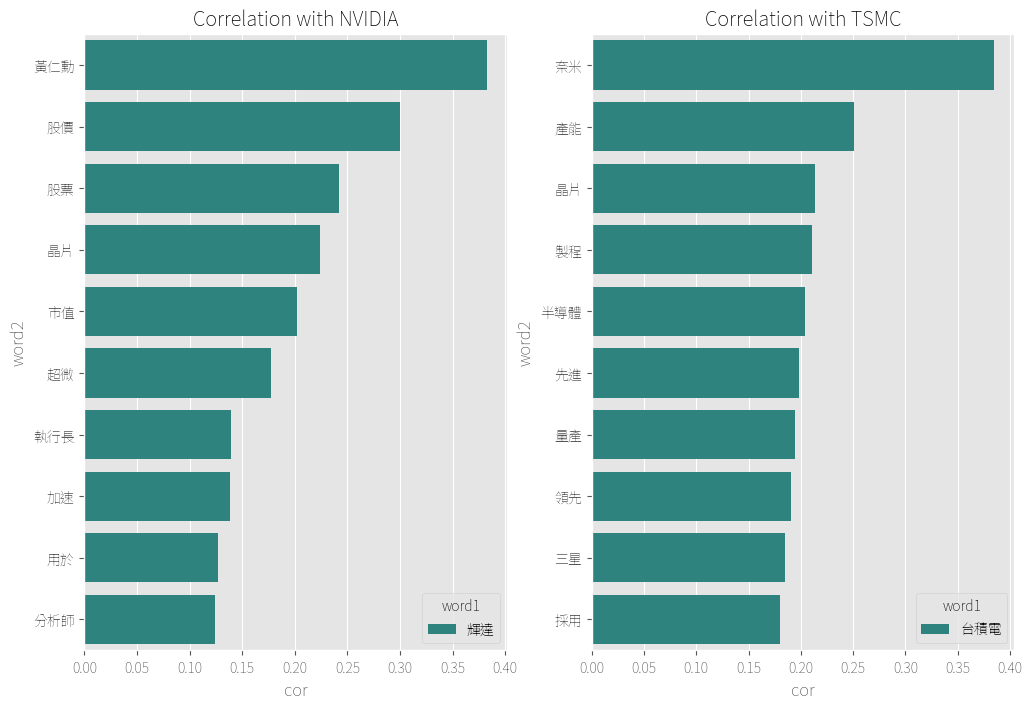

In [171]:
import seaborn as sns

plt.figure(figsize=(12, 8))
plt.style.use("ggplot")

plt.subplot(121)
sns.barplot(x='cor', y='word2', data=ai_sum, palette='viridis', hue='word1')
plt.title('Correlation with NVIDIA')

plt.subplot(122)
sns.barplot(x='cor', y='word2', data=tsmc_sum, palette='viridis', hue='word1')
plt.title('Correlation with TSMC')

plt.show()

### 相關性分析前十名

這裡我們分別對輝達（NVIDIA）和台積電（TSMC）進行了相關性分析，找出了與這兩個詞彙相關性最高的前十個詞彙。這些詞彙可能與輝達和台積電的產品、技術、市場等有關，反映了AI討論中的重要話題和關注點。

#### 輝達（NVIDIA）相關性分析

- 出現了黃仁勳、股價、晶片等說明了輝達在AI硬體領域的重要性，牽扯到不少股票、市值等經濟學術語，推測可能是討論輝達的市場表現、技術創新等。

#### 台積電（TSMC）相關性分析

- 主要重點是落在奈米、產能與晶片等，這些詞彙可能與台積電的技術、生產能力、產品等有關，反映了台積電在半導體行業的重要地位，也反應大眾看重台積電產能。此外也出現三星，這可能是討論台積電與三星在半導體市場的競爭或合作關係。

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 7: Plot Correlation Top 60 correlation > 0.3 繪製相關性前60名相關係數大於0.3</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Find top 60 by DTM 找出前60名</div>

In [172]:
# 找出相關係數大於0.3的前60名
most_freq_df = dtm_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [173]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_corr_df[(word_corr_df['word1'].isin(most_freq_word)) & (word_corr_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.3]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df.head()

,word1,word2,cor
0,沒有,不是,0.385641
1,正在,世界,0.456569
2,經濟,中國,0.352612
3,美國,中國,0.562551
4,大學,人才,0.445270


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Create Network Plot 建立網絡圖</div>

In [176]:
# Create network plot
G = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    G.add_edge(filtered_df['word1'][i], filtered_df['word2'][i], weight=filtered_df['cor'][i])
    
# 取得edge權重
weights = [w[2]['weight']*0.1 for w in  G.edges(data=True)]

# Create pyvis network
net = Network(height="600px", width="100%", bgcolor="#222222", font_color="white", notebook=True)

# 設定 nodes
net.from_nx(G)
net.show_buttons(filter_=['physics'])
net.show("plot/correlation.html")

plot/correlation.html


### 相關性分析前60名

我們可以發現台積電與奈米與半導體高度相關，而輝達與黃仁勳相關。此外我們看出台灣會與半導體、供應鏈與製造相關，說明台灣在半導體產業的重要性。比較有意思的是出現了股價、分析師與業務相關，這可能是討論股市與公司業務進行分析的討論。最後，國家關係上，美國與投資有關，而中國與經濟相關，這可能是討論中國經濟與美國投資對台灣人工智慧產業的影響。

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 8: Document Similarity 文件相似度</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">TF-IDF 計算</div>

In [177]:
data_cos = data_corr.copy()
data_cos.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\r\n【公司名稱】Influx FinTech 普匯金融科技\r\n\r\n【工作...,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,實習 普匯 金融 科技 職缺 徵求 商管 科系 曾經 接觸 關注 時事 議題 國內外 金融 ...
1,2,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,[新聞]台銀「三駕馬車」戰略發威前4月,2022-05-21 02:29:23,（中央社記者張璦台北20日電）台灣銀行消金、企金、政府部門業務「三駕馬車」再發威\r\n，董...,中央社記者張璦台北日電台灣銀行消金企金政府部門業務三駕馬車再發威董事長呂桔誠今天表示台銀今年...,中央社 張璦 台北 日電 台灣 銀行 消金 企金 部門 業務 三駕 馬車 發威 董事長 呂桔...
2,3,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,[新聞]央行徵才月薪最高86K,2023-02-14 11:45:19,https://tinyurl.com/3fcp6ehh\r\n記者陳美君／台北報導\r\n...,記者陳美君台北報導年月日週二上午擁抱金飯碗的機會來了中央銀行近日公開徵才開出的職缺包括經濟金...,陳美君 台北 週二 上午 擁抱 金飯碗 中央 銀行 近日 公開 徵才 開出 職缺 經濟 金融...
3,4,https://www.ptt.cc/bbs/Finance/M.1698684536.A....,[新聞]證交所徵才開創數位驅動時代報名至11/17,2023-10-31 00:48:54,證交所徵才開創數位驅動時代 報名至11/17止\r\n\r\n中央社\r\n2023年10月...,證交所徵才開創數位驅動時代報名至止中央社年月日週一下午中央社記者潘智義台北年月日電台灣證券交...,證交所 徵才 開創 數位 驅動 時代 報名 至止 中央社 週一 下午 中央社 潘智義 台北 ...
4,5,https://www.ptt.cc/bbs/job/M.1641165773.A.E67....,[台中][西屯］飛斯戴爾有限公司/日文客服,2022-01-03 07:22:51,job版禁止張貼違反「\r\n就業服務法\r\n」、\r\n「\r\n性別平等工作法\r\n...,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...,禁止 張貼 違反 就業 服務法 性別平等 工作法 勞基法 文章 發文 同意 一切 遵循 確知...


In [183]:
transformer = TfidfTransformer()
print(transformer)
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)

# 轉成dataframe
tfidf_df = pd.DataFrame(columns=vocabulary, data=tfidf.toarray())
tfidf_df.head()

TfidfTransformer()


,一些,一年,一樣,一直,三星,上市,上漲,下半年,不僅,不得,...,面臨,項目,預測,領先,顯示,風險,馬斯克,高階,鴻海,黃仁勳
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.069462,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Cosine Similarity 計算餘弦相似度</div>

In [185]:
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())

# 轉成dataframe
cosine_df = pd.DataFrame(cosine_matrix[0], columns=['cos_similarity'])

cosine_df.head()

,cos_similarity
0,1.000000
1,0.604837
2,0.584849
3,0.057999
4,0.000000


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Top 10 Similarity Analysis 相似度分析前十名</div>

In [186]:
cosine_df = cosine_df.merge(data_cos, how='left', left_index=True, right_index=True)
cosine_df.loc[:, ["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
0,1.000000,[徵才]普匯金融科技-金融科技行銷/金融實習生,https://www.ptt.cc/bbs/Finance/M.1644917373.A....
386,0.722195,[新聞]中信金：元宇宙分行預計2023年上線,https://www.ptt.cc/bbs/Stock/M.1666938511.A.E6...
1,0.604837,[新聞]台銀「三駕馬車」戰略發威前4月,https://www.ptt.cc/bbs/Finance/M.1653071365.A....
321,0.600026,[新聞]數位轉型正重塑金融體系,https://www.ptt.cc/bbs/Stock/M.1658132813.A.88...
388,0.594361,[新聞]元宇宙分行超夯!一文抓住金融科技展公民營金控亮點,https://www.ptt.cc/bbs/Stock/M.1667053088.A.5F...
331,0.587489,[請益]【線上心理實驗徵求受試者】,https://www.ptt.cc/bbs/Stock/M.1658906958.A.6D...
2,0.584849,[新聞]央行徵才月薪最高86K,https://www.ptt.cc/bbs/Finance/M.1676346325.A....
1468,0.552621,[新聞]一銀盜領案功臣也棄鐵飯碗 資安警官4特,https://www.ptt.cc/bbs/Tech_Job/M.1652212500.A...
581,0.517684,[新聞]摩根大通註冊IndexGPT搶推AI財務顧問服務,https://www.ptt.cc/bbs/Stock/M.1685204161.A.85...
146,0.498208,[徵才]AlphaIntelligence徵Full-stack(70K+),https://www.ptt.cc/bbs/Soft_Job/M.1647686817.A...


In [187]:
cos_df_14 = pd.DataFrame(cosine_matrix[14], columns=['cos_similarity'])

cos_df_14 = cos_df_14.merge(data_cos, how='left', left_index=True, right_index=True)
cos_df_14.loc[:, ["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
19,1.000000,[台北]國立臺灣師範大學教育部計畫專任助理,https://www.ptt.cc/bbs/job/M.1645685566.A.970....
14,1.000000,[台北]國立臺灣師範大學教育部計畫專任助理,https://www.ptt.cc/bbs/job/M.1644202295.A.75E....
7,1.000000,[台北]國立臺灣師範大學教育部計畫專任助理,https://www.ptt.cc/bbs/job/M.1642382909.A.5D7....
5,0.995820,[台北]國立臺灣師範大學教育部計畫專任助理,https://www.ptt.cc/bbs/job/M.1641369547.A.B96....
91,0.540440,[台北]臺大國發所徵碩士級專任研究助理,https://www.ptt.cc/bbs/job/M.1717133780.A.877....
20,0.530300,[北部]長庚大學工學院誠徵學士級專任助理,https://www.ptt.cc/bbs/job/M.1645777447.A.271....
82,0.525172,[台北]台大國發所誠徵計畫碩士級專任研究助理,https://www.ptt.cc/bbs/job/M.1703126231.A.8F8....
27,0.514622,[北部]清大動機國際期刊學士/碩士級助理,https://www.ptt.cc/bbs/job/M.1650005890.A.3C3....
77,0.513197,[台北]台大醫院麻醉部誠徵專任研究助理,https://www.ptt.cc/bbs/job/M.1689776786.A.454....
54,0.505466,[南部]成大電機系徵求博士後研究員,https://www.ptt.cc/bbs/job/M.1663148496.A.490....


### 觀察

第一筆相關查找成效較差，可能是因為文章內容較為廣泛，沒有明顯的主題。第十五筆相關查找成效較好，可能是因為文章內容較為專注，有明確的主題。這些結果表明，文本相似度計算可以幫助我們找到相關性較高的文章，進一步了解文本之間的關係。

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 9: N-Grams Generator N-Grams 生成器</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">N-grams function N-grams 函數</div>

In [188]:
data3 = clear_df.copy()

sentence_tokens = data3.sentence.progress_apply(get_token).tolist()
sentence_tokens[:5]

100%|██████████| 2172/2172 [00:04<00:00, 470.96it/s]


[['實習',
  '普匯',
  '金融',
  '科技',
  '職缺',
  '徵求',
  '商管',
  '科系',
  '曾經',
  '接觸',
  '關注',
  '時事',
  '議題',
  '國內外',
  '金融',
  '科技',
  '趨勢',
  '議題',
  '興趣',
  '熟悉',
  '軟體',
  '社群',
  '軟體',
  '圖文',
  '影音',
  '創作',
  '額外',
  '加分',
  '經驗',
  '額外',
  '加分',
  '操作',
  '過線',
  '上線',
  '行銷',
  '活動',
  '媒體',
  '經營',
  '經驗',
  '額外',
  '加分',
  '薪資',
  '待遇',
  '實習',
  '連絡',
  '投遞',
  '履歷',
  '地點',
  '台北市',
  '中山區',
  '松江路',
  '號樓',
  '週三',
  '天可議',
  '午休',
  '一小時',
  '指導',
  '協助',
  '廣告',
  '投放',
  '社群',
  '經營',
  '圖文',
  '撰寫',
  '行銷',
  '提案',
  '執行',
  '蒐集',
  '分析',
  '福利',
  '三節',
  '獎品',
  '備註',
  '簡介',
  '普匯',
  '金融',
  '科技',
  '具備',
  '專業',
  '風險',
  '管理',
  '金融',
  '設計',
  '高端',
  '科技',
  '組成',
  '互利',
  '互信',
  '公開',
  '透明',
  '溫度',
  '金融',
  '服務',
  '立志',
  '串起',
  '社會',
  '閒置',
  '資源',
  '協助',
  '年輕人',
  '夢想',
  '金融',
  '一支',
  '最具',
  '速度',
  '紀律',
  '績效',
  '邀請',
  '一起',
  '加入',
  '開創',
  '年輕',
  '移動',
  '金融',
  '服務',
  '共同',
  '邁向',
  '國際',
  '舞台',
  '創立',
  '金融',
  '科技',
  '獨角獸',
  '高端',


In [189]:
def ngram(documents, n=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i + n])) for i in range(len(split_words) - n + 1)]
        # 計算分母
        [words.append(tuple(split_words[i:i + n - 1])) for i in range(len(split_words) - n + 2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:n - 1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:n - 1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Bi-grams prediction 二元詞預測</div>

In [190]:
# Bi-gram prediction
bi_prediction = ngram(sentence_tokens, 2)

In [191]:
text = '深度學習'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 演算法, probability: 0.0476
next word: 技術, probability: 0.044
next word: 機器學習, probability: 0.0403
next word: 工程師, probability: 0.0256
next word: 即可, probability: 0.022


In [192]:
text = '顯示卡'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 訂單, probability: 0.0714
next word: 輝達, probability: 0.0476
next word: 音效卡, probability: 0.0476
next word: 至少, probability: 0.0238
next word: 進入, probability: 0.0238


In [194]:
text = '自動駕駛'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 汽車, probability: 0.0994
next word: 技術, probability: 0.0552
next word: 特斯拉, probability: 0.0276
next word: 業務, probability: 0.0276
next word: 晶片, probability: 0.0221


### 二元詞預測

- 我們可以看到當使用深度學習作為輸入時，最有可能的下一個詞是演算法、技術、機器學習、工程師和即可。這些詞彙可能與深度學習相關，反映了AI討論中的重要話題和關注點。
- 關於顯示卡，最有可能的下一個詞是訂單、輝達、音效卡、至少和進入。這些詞彙可能與顯示卡的市場、技術、應用等有關。
- 最後，當使用自動駕駛作為輸入時，最有可能的下一個詞是汽車、技術、特斯拉、業務和晶片。這些詞彙可能與自動駕駛技術、應用、市場等有關。也提到了特斯拉，這可能是因為特斯拉在自動駕駛領域的重要性。

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Tri-grams prediction 三元詞預測</div>

In [200]:
# Tri-gram prediction
tri_prediction = ngram(sentence_tokens, 3)

In [210]:
text = '碩士起薪'
next_words = list(tri_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 資歷, probability: 0.4
next word: 年資, probability: 0.3
next word: 學士, probability: 0.2
next word: 調整, probability: 0.1


In [211]:
text = '學士起薪'
next_words = list(tri_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 碩士, probability: 1


### 三元詞預測

- 我們可以看到當使用碩士起薪作為輸入時，最有可能的下一個詞是資歷、年資、學士、調整和經驗。這些詞彙可能與學歷、工作經驗、薪資調整等有關，反映了討論中的相關話題。
- 關於學士起薪，最有可能的下一個詞是碩士。推測學士薪資會與碩士薪資做比較，這可能是討論學歷對薪資的影響。

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 10: Conclusion 結論</div>

### 結論

- 通過文本分析，我們可以了解到AI討論中的主要話題和關注點，如半導體、主要科技公司（台積電、輝達、微軟）、以及重要的國家角色（中國、美國、台灣）。
- 透過N-grams分析，我們可以發現一些詞彙應該是一起出現的，例如：聊天機器人、先進封裝、基礎設施等，這些詞彙可能需要更新用戶自定義辭典，以便斷詞更加準確。
- 通過相關性分析，我們可以找出與輝達和台積電相關性最高的前十個詞彙，這些詞彙可能與輝達和台積電的產品、技術、市場等有關，反映了AI討論中的重要話題和關注點。
- 通過文本相似度計算，我們可以找到相關性較高的文章，進一步了解文本之間的關係。
- 通過N-grams生成器，我們可以預測下一個詞彙，進一步了解文本之間的關係。